# Applied Data Science Capstone - The Battle of Neighborhoods
## Analysis of Restaurants in Barcelona
- Import libraries
- Data collection and preprocessing
    1. Obtain neighborhoods DataFrame from Barcelona Open Data Repository
    2. Get neighborhoods coordinates
    3. Extract venue data
    4. Complete venue data with foursquare premium data
- Exploratory Analysis
    1. Univariant Analysis
    2. Multivariant analysis
- Cluster Analysis
    1. K-means optimization (best k selection)
    2. Model fitting
    3. Results Analysis


## Import Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install folium
import folium # map rendering library

# Clustering modules
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

     |████████████████████████████████| 92kB 6.9MB/s eta 0:00:011


## Data collection and preprocessing
### 1. Obtain neighborhoods DataFrame from Barcelona Open Data Repository

Open Data Barcelona is a data repository created by Barcelona public administrations with the main objective of "maximize available public resources, exposing the information generated or guarded by public bodies, allowing its access and use for the common good and for the benefit of anyone and any entity interested"
(https://opendata-ajuntament.barcelona.cat/en).

This repository contains a huge and diverse bunch of data sets. In this case, we will use the data set of administrative units of the city.

In [3]:
# Data set url
url = 'https://opendata-ajuntament.barcelona.cat/data/dataset/808daafa-d9ce-48c0-925a-fa5afdb1ed41/resource/4cc59b76-a977-40ac-8748-61217c8ff367/download/districtes_i_barris_170705.csv'
df = pd.read_csv(url, encoding='utf-8', sep=",")
df.columns = ['BoroughID','Borough','NeighborhoodID','Neighborhood']
df.head()

BoroughID       Borough  NeighborhoodID  \
0          1  Ciutat Vella               1   
1          1  Ciutat Vella               2   
2          1  Ciutat Vella               3   
3          1  Ciutat Vella               4   
4          2      Eixample               5   

                            Neighborhood  
0                               el Raval  
1                         el Barri Gòtic  
2                         la Barceloneta  
3  Sant Pere, Santa Caterina i la Ribera  
4                          el Fort Pienc

### 2. Get neighborhoods coordinates

In [4]:
geolocator = Nominatim(user_agent="geouser")

# Function that gets geographic coordinates of each neighborhood of Barcelona
def get_Coord(row):
    
    location = None
    c=0
    # Sometimes geopy is not able to get the coordinates at first try.
    while location == None and c<100:
        try:
            location = geolocator.geocode(row['Neighborhood'] + ', ' + row['Borough'] + ', Barcelona')
        except:
            pass
        c+=1

    if location == None:
        return (np.NaN, np.NaN)
    else:
        return (location.latitude, location.longitude)

In [5]:
# Apply get_Coord to each dataframe row
df['coords'] = df.apply(get_Coord, axis=1)
df['Latitude'] = df['coords'].apply(lambda x: x[0])
df['Longitude'] = df['coords'].apply(lambda x: x[1])
df.drop(columns="coords",inplace=True)
df.head()

BoroughID       Borough  NeighborhoodID  \
0          1  Ciutat Vella               1   
1          1  Ciutat Vella               2   
2          1  Ciutat Vella               3   
3          1  Ciutat Vella               4   
4          2      Eixample               5   

                            Neighborhood   Latitude  Longitude  
0                               el Raval  41.379518   2.168368  
1                         el Barri Gòtic  41.383395   2.176912  
2                         la Barceloneta  41.380653   2.189927  
3  Sant Pere, Santa Caterina i la Ribera  41.386010   2.177838  
4                          el Fort Pienc  41.395925   2.182325

In [6]:
# Check if there is any NaN value
df[pd.isna(df.Latitude)]

BoroughID              Borough  NeighborhoodID  \
21          5  Sarrià-Sant Gervasi              22   

                             Neighborhood  Latitude  Longitude  
21  Vallvidrera, el Tibidabo i les Planes       NaN        NaN

In [7]:
# Manual correct missing values
df.loc[21,'Latitude'] = 41.4167
df.loc[21,'Longitude'] = 2.09472

In [8]:
# Check again
df[pd.isna(df.Longitude)]

Empty DataFrame
Columns: [BoroughID, Borough, NeighborhoodID, Neighborhood, Latitude, Longitude]
Index: []

Obtain the geojson with the neighborhoods boundaries from a GitHub repository
(https://github.com/martgnz/bcn-geodata).

In [9]:
url = 'https://raw.githubusercontent.com/martgnz/bcn-geodata/master/barris/barris.geojson'
geoNeighborhood = requests.get(url).json()

In [10]:
# Get geographical coordinate of BCN
address = 'Barcelona'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Barcelona are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Barcelona are 41.3828939, 2.1774322.


Check if all coordinates are correct with a cloropleph map.

In [11]:
# create a plain world map
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map
map_bcn.choropleth(
    geo_data=geoNeighborhood,
    data=df,
    columns=['Neighborhood', 'BoroughID'],
    key_on='properties.NOM',
    fill_color='Set3', 
    threshold_scale=10,
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Boroughs of Barcelona'
)

# Plot a marker for each neighborhood
for lat, lng, label in zip(df.Latitude, df.Longitude, df.Neighborhood):
    folium.CircleMarker(
        [lat, lng],
        radius=1, # define how big you want the circle markers to be
        color='black',
        #fill=True,
        popup=label,
        #fill_color='yellow',
        #fill_opacity=0.6
    ).add_to(map_bcn)


# display map
map_bcn

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [12]:
# Manually correct of all dataframe errors
df.loc[df.Neighborhood == 'el Poble Sec','Neighborhood'] = 'el Poble-sec'
df.loc[df.Neighborhood == 'Sant Andreu','Latitude'] = 41.4354095
df.loc[df.Neighborhood == 'Sant Andreu','Longitude'] = 2.1898201

In [13]:
# create a plain world map
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map
map_bcn.choropleth(
    geo_data=geoNeighborhood,
    data=df,
    columns=['Neighborhood', 'BoroughID'],
    key_on='properties.NOM',
    fill_color='Set3', 
    threshold_scale=10,
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Boroughs of Barcelona'
)

# Plot a marker for each neighborhood
for lat, lng, label in zip(df.Latitude, df.Longitude, df.Neighborhood):
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='black',
        popup=label,

    ).add_to(map_bcn)


# display map
map_bcn

### 3. Extract Venue Data

In [21]:
# The code was removed by Watson Studio for sharing.

In [22]:
# Define function to make all the Foursquare data requests
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'VenueID',
                  'Venue', 
                  'Category']
    
    return(nearby_venues)

In [23]:
bcn_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

el Raval
el Barri Gòtic
la Barceloneta
Sant Pere, Santa Caterina i la Ribera
el Fort Pienc
la Sagrada Família
la Dreta de l'Eixample
l'Antiga Esquerra de l'Eixample
la Nova Esquerra de l'Eixample
Sant Antoni
el Poble-sec
la Marina del Prat Vermell
la Marina de Port
la Font de la Guatlla
Hostafrancs
la Bordeta
Sants - Badal
Sants
les Corts
la Maternitat i Sant Ramon
Pedralbes
Vallvidrera, el Tibidabo i les Planes
Sarrià
les Tres Torres
Sant Gervasi - la Bonanova
Sant Gervasi - Galvany
el Putxet i el Farró
Vallcarca i els Penitents
el Coll
la Salut
la Vila de Gràcia
el Camp d'en Grassot i Gràcia Nova
el Baix Guinardó
Can Baró
el Guinardó
la Font d'en Fargues
el Carmel
la Teixonera
Sant Genís dels Agudells
Montbau
la Vall d'Hebron
la Clota
Horta
Vilapicina i la Torre Llobeta
Porta
el Turó de la Peira
Can Peguera
la Guineueta
Canyelles
les Roquetes
Verdun
la Prosperitat
la Trinitat Nova
Torre Baró
Ciutat Meridiana
Vallbona
la Trinitat Vella
Baró de Viver
el Bon Pastor
Sant Andreu
la Sagrer

In [24]:
bcn_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     el Raval              41.379518                2.168368   
1     el Raval              41.379518                2.168368   
2     el Raval              41.379518                2.168368   
3     el Raval              41.379518                2.168368   
4     el Raval              41.379518                2.168368   

                    VenueID        Venue            Category  
0  53b5d201498ea7ec7d3f3b9d        Arume  Spanish Restaurant  
1  5418c80e498ea121b0f7f3bb     Chulapio        Cocktail Bar  
2  4e1c064c81dc8ea8b58cc50c      Cera 23  Spanish Restaurant  
3  52ffc95e498e5f219673b9d1    A Tu Bola    Tapas Restaurant  
4  547901fc498eb0f50ce007a4  La Robadora           Gastropub

In [25]:
# Check number of venues for each Neighborhood
Nvenues = bcn_venues.groupby('Neighborhood')['VenueID'].count()
Nvenues = Nvenues.reset_index()
Nvenues
df['Nvenues'] = Nvenues.VenueID

In [26]:
# create a plain world map
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth map 
map_bcn.choropleth(
    geo_data=geoNeighborhood,
    data=df,
    columns=['Neighborhood', 'Nvenues'],
    key_on='properties.NOM',
    fill_color='OrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Venues of Barcelona'
)


# display map
map_bcn

In [63]:
# Subset to venues whose categories contains "Restaurant"
df_rest = bcn_venues[bcn_venues.Category.str.contains(' Restaurant')]
# Drop categories with less than 10 occurences
keep = df_rest.groupby('Category').Venue.count() > 10
keep = keep[keep].index.tolist()
df_rest = df_rest[df_rest.Category.isin(keep)].reset_index(drop=True)
df_rest.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     el Raval              41.379518                2.168368   
1     el Raval              41.379518                2.168368   
2     el Raval              41.379518                2.168368   
3     el Raval              41.379518                2.168368   
4     el Raval              41.379518                2.168368   

                    VenueID          Venue                  Category  
0  53b5d201498ea7ec7d3f3b9d          Arume        Spanish Restaurant  
1  52ffc95e498e5f219673b9d1      A Tu Bola          Tapas Restaurant  
2  4e1c064c81dc8ea8b58cc50c        Cera 23        Spanish Restaurant  
3  53347f6611d28af55005835a      La Monroe        Spanish Restaurant  
4  4b4d9934f964a5209bd426e3  Las Fernández  Mediterranean Restaurant

In [64]:
# Drop duplicate venues
df_rest.drop_duplicates(subset='VenueID', inplace=True)
df_rest = df_rest.reset_index(drop=True)
df_rest

Neighborhood  Neighborhood Latitude  \
0                                        el Raval              41.379518   
1                                        el Raval              41.379518   
2                                        el Raval              41.379518   
3                                        el Raval              41.379518   
4                                        el Raval              41.379518   
5                                        el Raval              41.379518   
6                                        el Raval              41.379518   
7                                        el Raval              41.379518   
8                                        el Raval              41.379518   
9                                        el Raval              41.379518   
10                                       el Raval              41.379518   
11                                       el Raval              41.379518   
12                                       el Raval              41.379518   
13                                       el Raval              41.379518   
14                                       el Raval              41.379518   
15                                       el Raval              41.379518   
16                                       el Raval              41.379518   
17                                       el Raval              41.379518   
18                                       el Raval              41.379518   
19                                       el Raval              41.379518   
20                                       el Raval              41.379518   
21                                       el Raval              41.379518   
22                                       el Raval              41.379518   
23                                       el Raval              41.379518   
24                                       el Raval              41.379518   
25                                       el Raval              41.379518   
26                                       el Raval              41.379518   
27                                       el Raval              41.379518   
28                                       el Raval              41.379518   
29                                       el Raval              41.379518   
..                                            ...                    ...   
648                                   el Poblenou              41.400527   
649                                   el Poblenou              41.400527   
650                                   el Poblenou              41.400527   
651                                   el Poblenou              41.400527   
652                                   el Poblenou              41.400527   
653                                   el Poblenou              41.400527   
654                                   el Poblenou              41.400527   
655  Diagonal Mar i el Front Marítim del Poblenou              41.403173   
656  Diagonal Mar i el Front Marítim del Poblenou              41.403173   
657  Diagonal Mar i el Front Marítim del Poblenou              41.403173   
658  Diagonal Mar i el Front Marítim del Poblenou              41.403173   
659  Diagonal Mar i el Front Marítim del Poblenou              41.403173   
660  Diagonal Mar i el Front Marítim del Poblenou              41.403173   
661  Diagonal Mar i el Front Marítim del Poblenou              41.403173   
662                         el Besòs i el Maresme              41.414979   
663                         el Besòs i el Maresme              41.414979   
664                       Provençals del Poblenou              41.412360   
665                       Provençals del Poblenou              41.412360   
666                       Provençals del Poblenou              41.412360   
667                       Provençals del Poblenou              41.412360   
668                       Provençals del Poblenou              41.412360   
669      

In [53]:
# Restaurants count by Neighborhood
df_rest.groupby('Neighborhood').Venue.count()

Neighborhood
Baró de Viver                                    1
Can Baró                                         7
Can Peguera                                      1
Canyelles                                        1
Diagonal Mar i el Front Marítim del Poblenou     7
Horta                                            9
Hostafrancs                                     17
Montbau                                          3
Navas                                            9
Pedralbes                                        5
Porta                                            7
Provençals del Poblenou                          7
Sant Andreu                                     13
Sant Antoni                                     23
Sant Genís dels Agudells                         1
Sant Gervasi - Galvany                          25
Sant Gervasi - la Bonanova                       4
Sant Martí de Provençals                         5
Sant Pere, Santa Caterina i la Ribera           16
Sants             

### 4. Complete venue data with foursquare premium data

To improve the informative potential of the dataset I have decided to get some additional venue details like price ranges, the venue rating and the number of likes. However, these endpoints required Premium calls to Foursquare API (maximum of 500 calls/day).  

In [22]:
# Define function to make all the Foursquare data requests
def getVenueInfo(VenueID):

    # create the API request URL
    url="https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}".format(
        VenueID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    row = pd.Series(index=['VenueID','Price','Rating','Likes'])        
    # make the GET request
    venue = requests.get(url).json()
    # return only relevant information for each nearby venue
    row['VenueID'] = VenueID
    try:
        row['Price'] = venue['response']['venue']['price']['tier']
    except:
        pass
    try:
        row['Rating'] = venue['response']['venue']['rating']
    except:
        pass
    try:
        row['Likes'] = venue['response']['venue']['likes']['count']
    except:
        pass
    return(row)

In [66]:
# I can only make 500 premium requests per day, so I'll get all premium data in two days
metrics = df_rest.VenueID[0:500].apply(getVenueInfo)

In [67]:
a = pd.merge(df_rest, metrics, how='left', left_on=['VenueID'], right_on=['VenueID'])
a.to_csv('venues.csv', index=False)

In [15]:
df_rest = pd.read_csv('venues.csv')
df_rest.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     el Raval              41.379518                2.168368   
1     el Raval              41.379518                2.168368   
2     el Raval              41.379518                2.168368   
3     el Raval              41.379518                2.168368   
4     el Raval              41.379518                2.168368   

                    VenueID          Venue                  Category  Price  \
0  53b5d201498ea7ec7d3f3b9d          Arume        Spanish Restaurant    2.0   
1  52ffc95e498e5f219673b9d1      A Tu Bola          Tapas Restaurant    1.0   
2  4e1c064c81dc8ea8b58cc50c        Cera 23        Spanish Restaurant    2.0   
3  53347f6611d28af55005835a      La Monroe        Spanish Restaurant    2.0   
4  4b4d9934f964a5209bd426e3  Las Fernández  Mediterranean Restaurant    2.0   

   Rating  Likes  
0     9.1  364.0  
1     8.9  389.0  
2     8.9  351.0  
3     8.8  396.0  
4     8.9  141.0

In [23]:
metrics = df_rest.VenueID[500:].apply(getVenueInfo)

In [32]:
df_rest.loc[500:,['Price','Rating','Likes']] = metrics.loc[:,['Price','Rating','Likes']]

In [34]:
df_rest.to_csv('venues_metrics.csv', index=False)

In [53]:
# Complete dataframe
df_rest = pd.merge(df_rest, df.loc[:,['Borough','Neighborhood']], how='left', left_on=['Neighborhood'], right_on=['Neighborhood'])


In [54]:
# Check if there are missing values
for col in df_rest.columns:
    NAS = df_rest[col].isna().sum()
    print ('{}: {} missing values'.format(col,NAS))

Neighborhood: 0 missing values
Neighborhood Latitude: 0 missing values
Neighborhood Longitude: 0 missing values
VenueID: 0 missing values
Venue: 0 missing values
Category: 0 missing values
Price: 0 missing values
Rating: 29 missing values
Likes: 0 missing values
Borough: 0 missing values


In [91]:
# Drop every row that contains missing values
df_rest = df_rest.dropna(axis=0).reset_index(drop=True)
df_rest.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     el Raval              41.379518                2.168368   
1     el Raval              41.379518                2.168368   
2     el Raval              41.379518                2.168368   
3     el Raval              41.379518                2.168368   
4     el Raval              41.379518                2.168368   

                    VenueID          Venue                  Category  Price  \
0  53b5d201498ea7ec7d3f3b9d          Arume        Spanish Restaurant    2.0   
1  52ffc95e498e5f219673b9d1      A Tu Bola          Tapas Restaurant    1.0   
2  4e1c064c81dc8ea8b58cc50c        Cera 23        Spanish Restaurant    2.0   
3  53347f6611d28af55005835a      La Monroe        Spanish Restaurant    2.0   
4  4b4d9934f964a5209bd426e3  Las Fernández  Mediterranean Restaurant    2.0   

   Rating  Likes       Borough  
0     9.1  364.0  Ciutat Vella  
1     8.9  389.0  Ciutat Vella  
2     8.9  351.0  Ciutat Vella  
3     8.8  396.0  Ciutat Vella  
4     8.9  141.0  Ciutat Vella

In [113]:
# Drop "Restaurant" word from categories because all of them must be restaurants
df_rest.Category = df_rest.Category.str.replace(' Restaurant', '')
df_rest.Price = df_rest.Price.astype('int')

In [115]:
# Save processed DataFrame
df_rest.to_csv('venues_metrics2.csv', index=False)

In [14]:
url = 'https://raw.githubusercontent.com/adlpecer/Coursera_Capstone/master/venues_metrics2.csv'
df_rest = pd.read_csv(url)

In [15]:
df_rest.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     el Raval              41.379518                2.168368   
1     el Raval              41.379518                2.168368   
2     el Raval              41.379518                2.168368   
3     el Raval              41.379518                2.168368   
4     el Raval              41.379518                2.168368   

                    VenueID          Venue       Category  Price  Rating  \
0  53b5d201498ea7ec7d3f3b9d          Arume        Spanish      2     9.1   
1  52ffc95e498e5f219673b9d1      A Tu Bola          Tapas      1     8.9   
2  4e1c064c81dc8ea8b58cc50c        Cera 23        Spanish      2     8.9   
3  53347f6611d28af55005835a      La Monroe        Spanish      2     8.8   
4  4b4d9934f964a5209bd426e3  Las Fernández  Mediterranean      2     8.9   

   Likes       Borough  
0  364.0  Ciutat Vella  
1  389.0  Ciutat Vella  
2  351.0  Ciutat Vella  
3  396.0  Ciutat Vella  
4  141.0  Ciutat Vella

## Exploratory Analysis

### 1. Univariant analysis

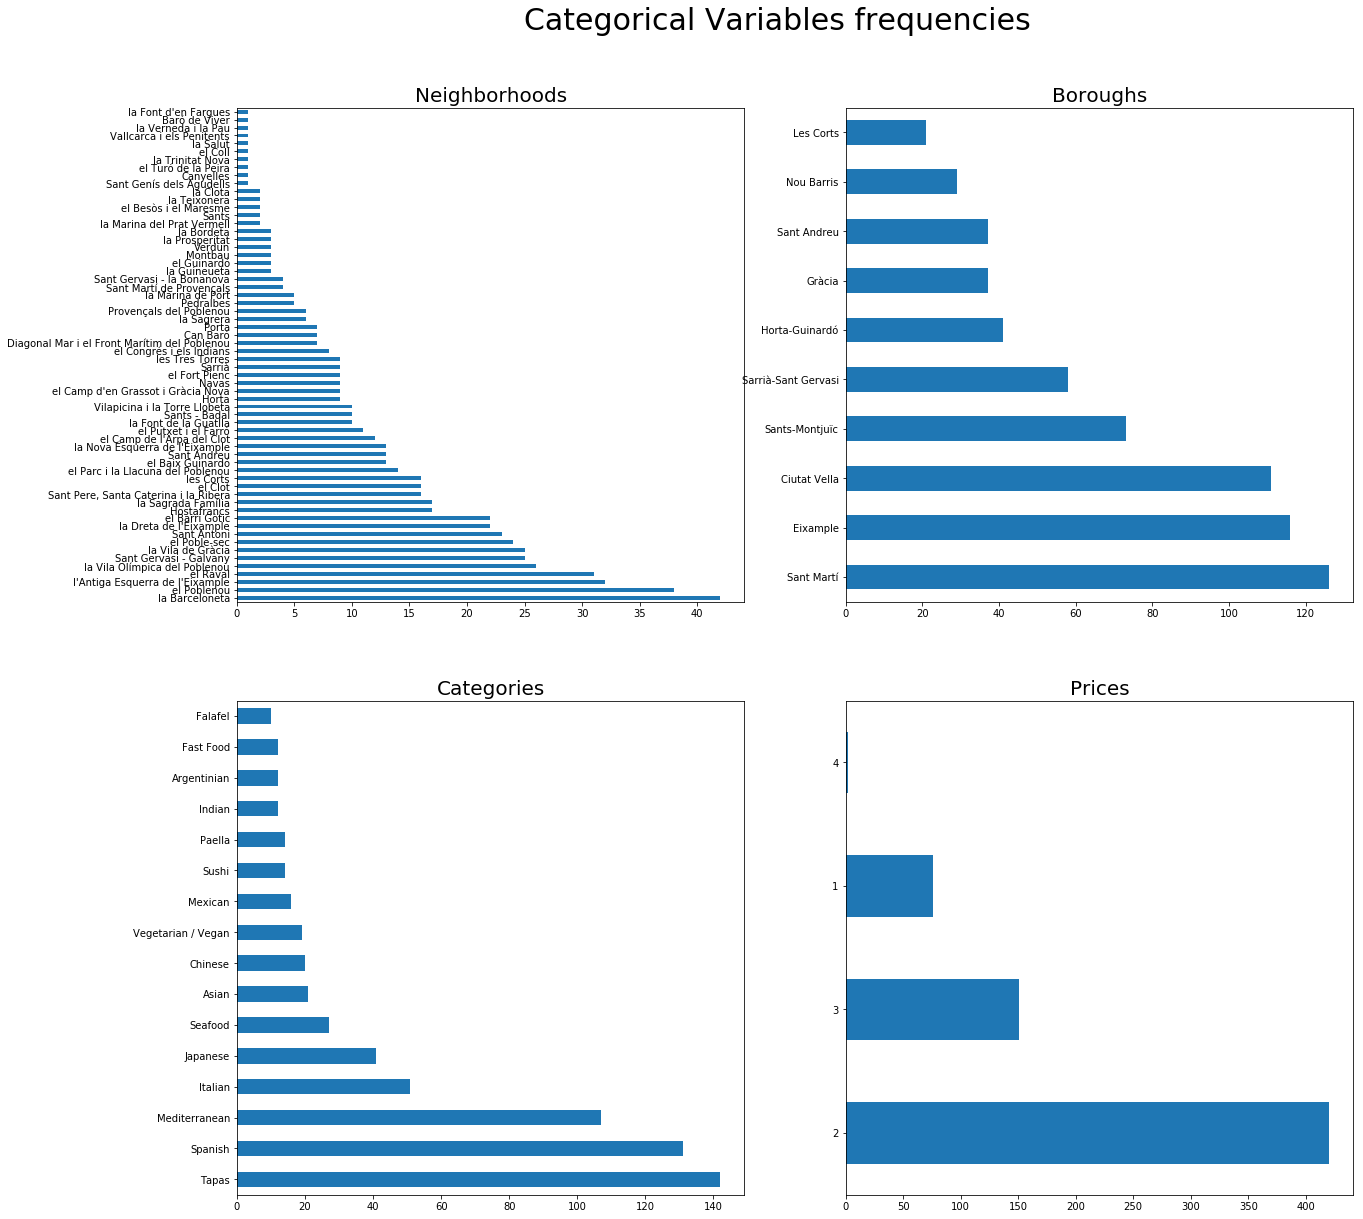

In [16]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Categorical Variables frequencies', fontsize=30, y=0.95)

ax1 = fig.add_subplot(221)
df_rest.Neighborhood.value_counts().plot(kind='barh', ax=ax1)
ax1.set_title('Neighborhoods', fontsize=20)

ax2 = fig.add_subplot(222)
df_rest.Borough.value_counts().plot(kind='barh', ax=ax2)
ax2.set_title('Boroughs', fontsize=20)

ax3 = fig.add_subplot(223)
df_rest.Category.value_counts().plot(kind='barh', ax=ax3)
ax3.set_title('Categories', fontsize=20)

ax4 = fig.add_subplot(224)
df_rest.Price.value_counts().plot(kind='barh', ax=ax4)
ax4.set_title('Prices', fontsize=20)

plt.show()

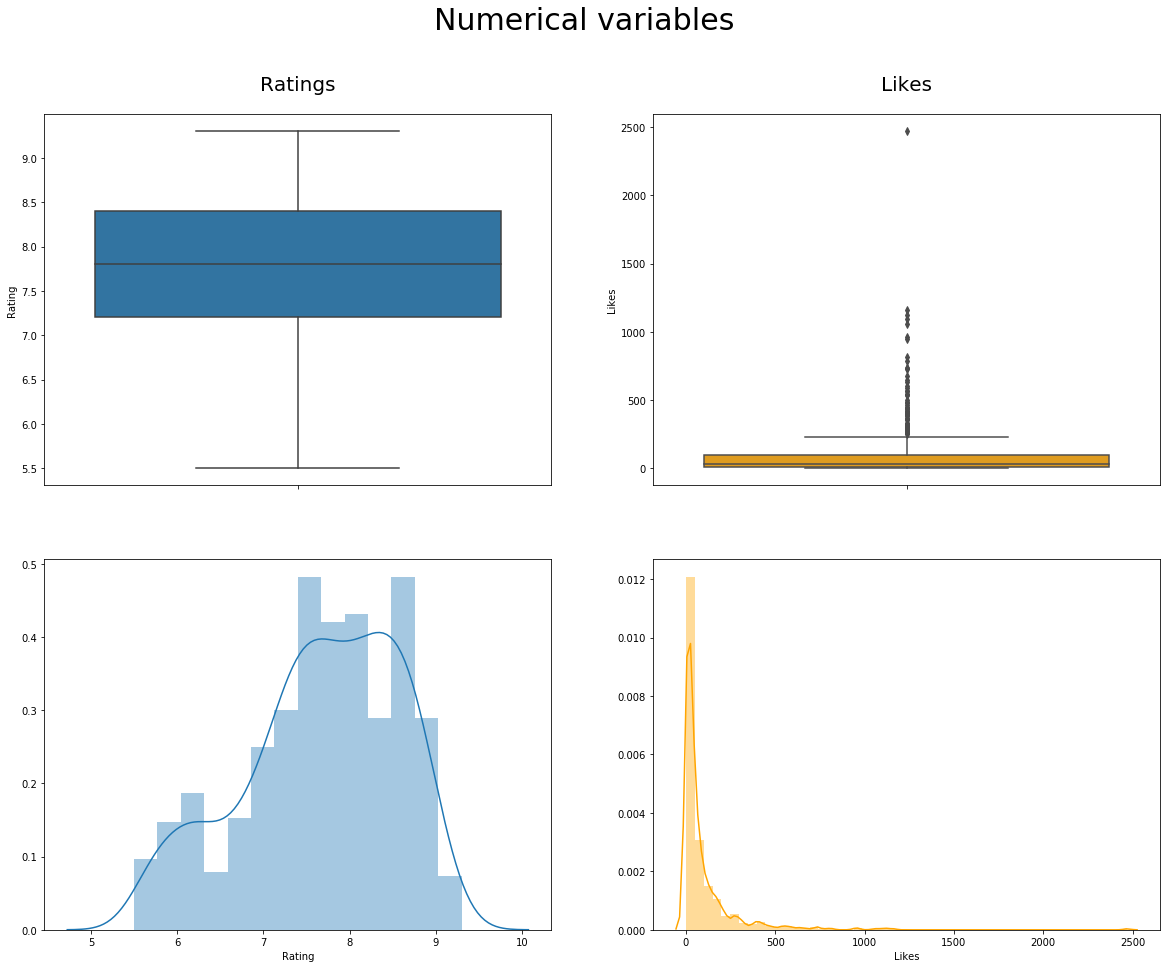

In [17]:
fig = plt.figure(figsize=(20,15))
fig.suptitle('Numerical variables', fontsize=30)

ax1 = fig.add_subplot(221)
sns.boxplot(y='Rating',data=df_rest, ax=ax1)
ax1.set_title('Ratings', fontsize=20, y=1.05)

ax2 = fig.add_subplot(222)
sns.boxplot(y='Likes',data=df_rest, ax=ax2, color='orange')
ax2.set_title('Likes', fontsize=20, y=1.05)

ax3 = fig.add_subplot(223)
sns.distplot(df_rest.Rating, ax=ax3)

ax4 = fig.add_subplot(224)
sns.distplot(df_rest.Likes, ax=ax4, color='orange')

plt.show()

### 2. Multivariant analysis

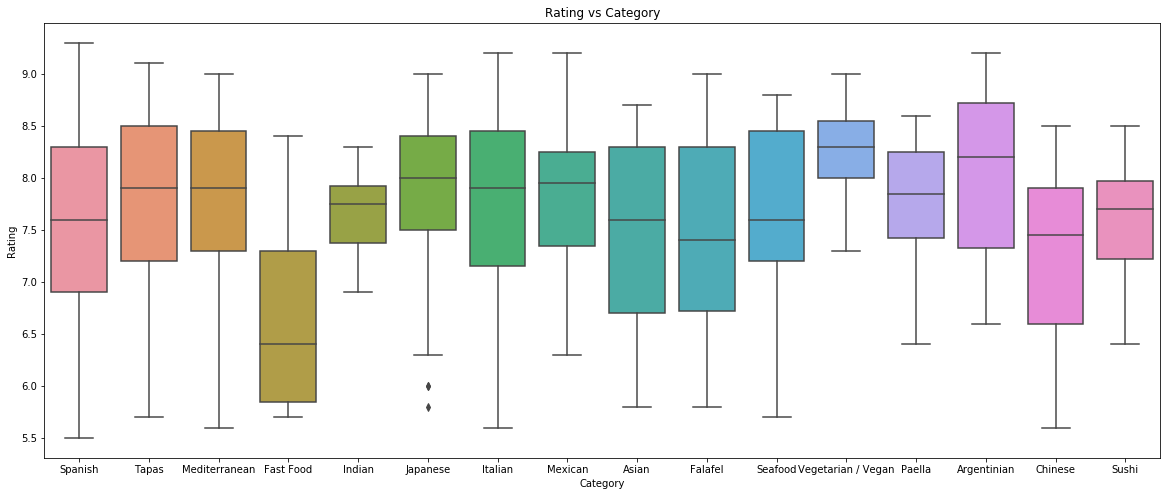

In [18]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Category',y='Rating',data=df_rest).set_title('Rating vs Category')
plt.show()

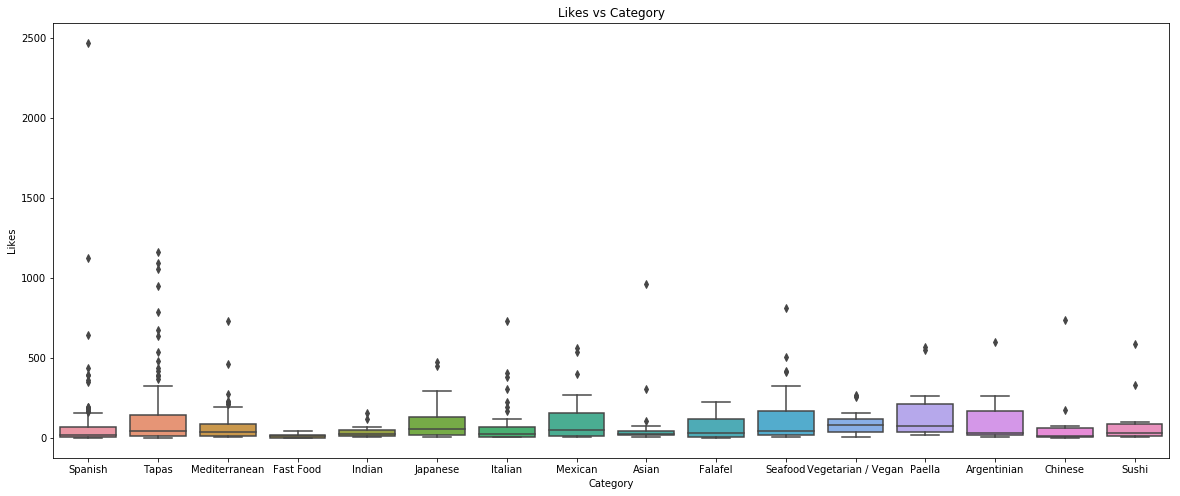

In [19]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Category',y='Likes',data=df_rest).set_title('Likes vs Category')
plt.show()

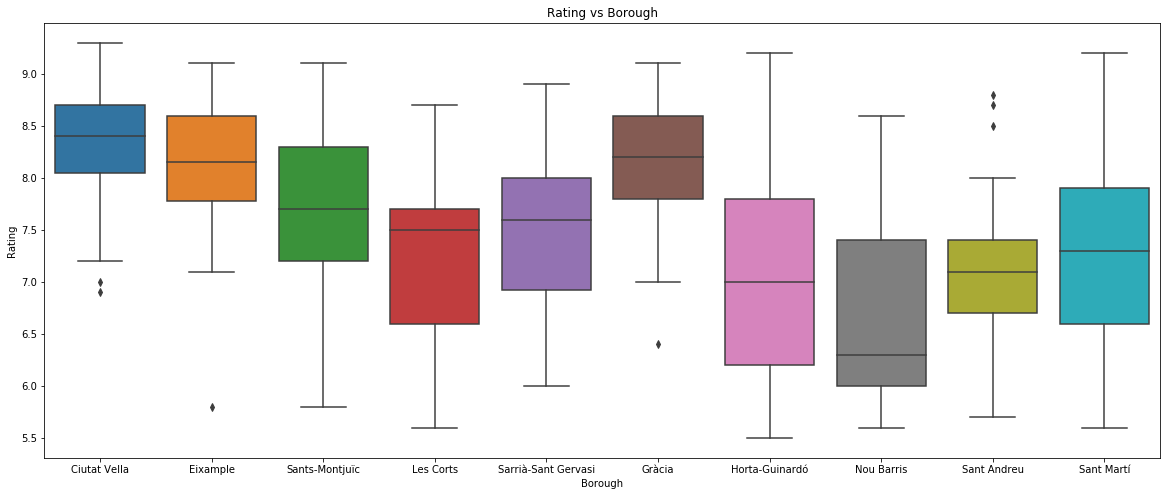

In [20]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Borough',y='Rating',data=df_rest).set_title('Rating vs Borough')
plt.show()

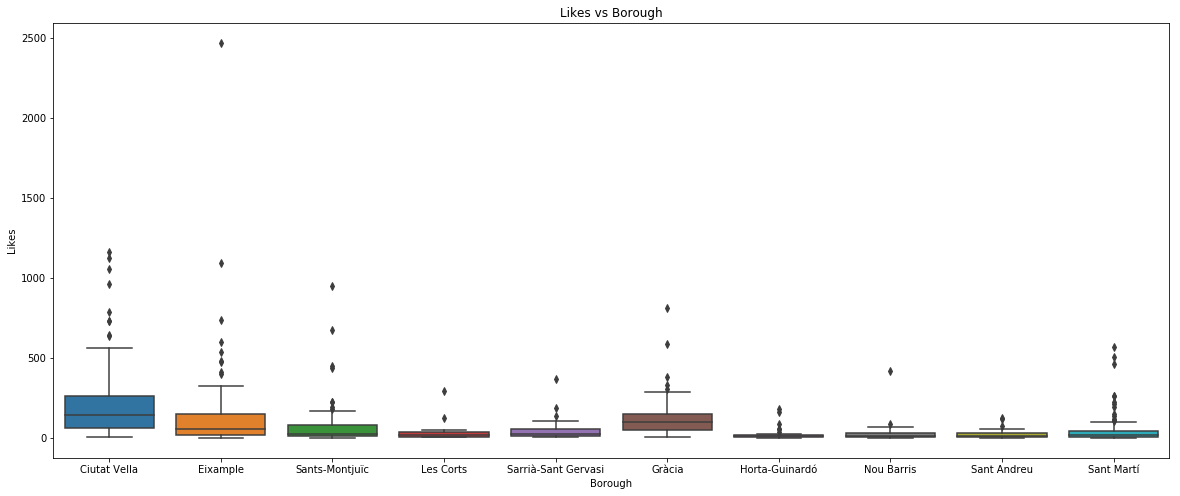

In [21]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Borough',y='Likes',data=df_rest).set_title('Likes vs Borough')
plt.show()

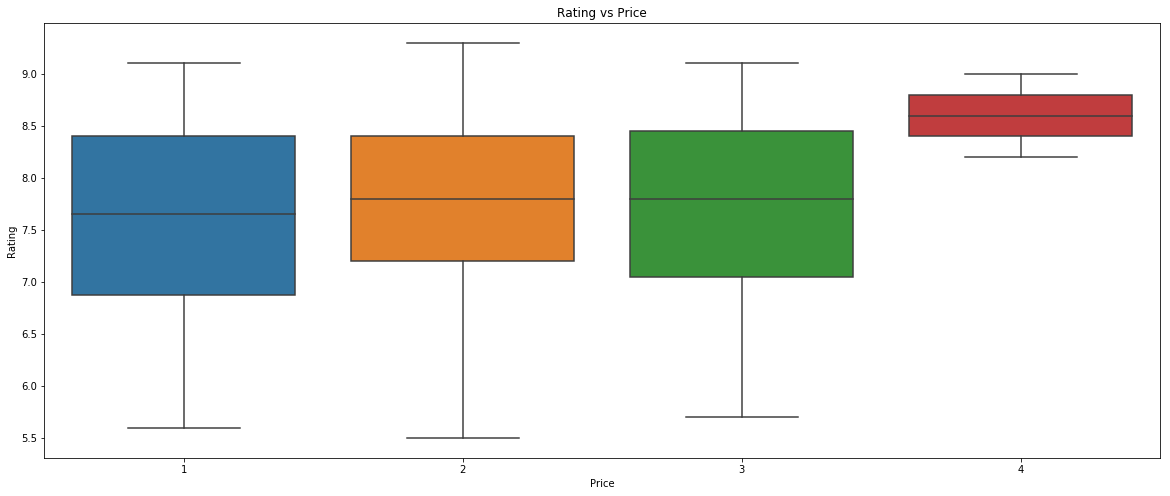

In [22]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Price',y='Rating',data=df_rest).set_title('Rating vs Price')
plt.show()

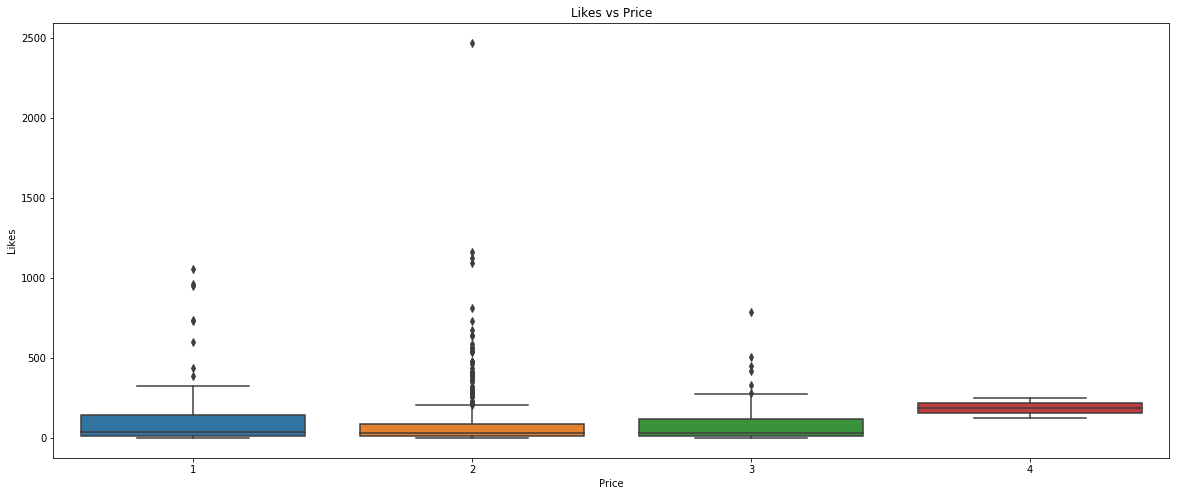

In [23]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Price',y='Likes',data=df_rest).set_title('Likes vs Price')
plt.show()

There are a high number of outliers at Likes feature. We can handle with that discretizing the likes in 4 ranges/categories.

In [24]:
df_rest['Likes.range'] = pd.qcut(df_rest.Likes,4,labels=False)

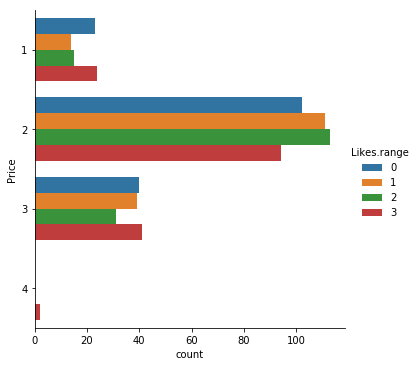

In [25]:
sns.catplot(y="Price", hue="Likes.range", kind="count",data=df_rest);

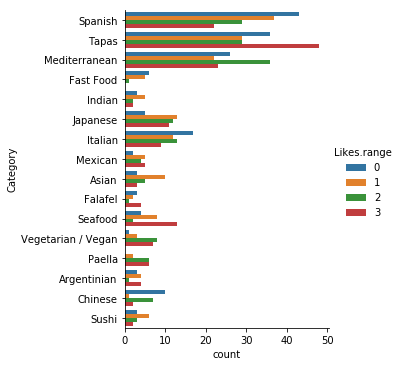

In [26]:
sns.catplot(y="Category", hue="Likes.range", kind="count",data=df_rest);

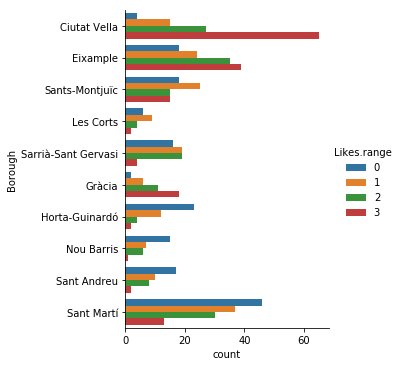

In [27]:
sns.catplot(y="Borough", hue="Likes.range", kind="count",data=df_rest);

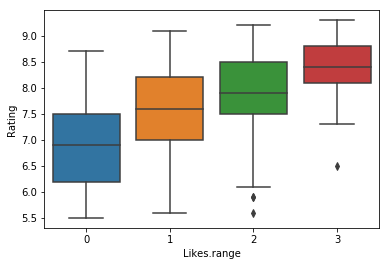

In [28]:
sns.boxplot(x='Likes.range',y='Rating',data=df_rest);

### 3. Venues Analysis by Neighborhoods

In [29]:
df_ml = df_rest[['Neighborhood','Borough','Price','Rating','Likes','Likes.range']]
cat_onehot = pd.get_dummies(df_rest[['Category']], prefix="", prefix_sep="")

In [30]:
df2 = pd.concat([df_ml,cat_onehot],axis=1)

In [31]:
df_grouped = df2.groupby(['Neighborhood','Borough']).mean().reset_index()

In [32]:
df_grouped.head()

Neighborhood         Borough     Price  \
0                                 Baró de Viver     Sant Andreu  2.000000   
1                                      Can Baró  Horta-Guinardó  2.000000   
2                                     Canyelles      Nou Barris  2.000000   
3  Diagonal Mar i el Front Marítim del Poblenou      Sant Martí  1.857143   
4                                         Horta  Horta-Guinardó  2.444444   

     Rating      Likes  Likes.range  Argentinian  Asian   Chinese  Falafel  \
0  5.800000  24.000000     1.000000          0.0    1.0  0.000000      0.0   
1  7.285714  46.857143     1.142857          0.0    0.0  0.142857      0.0   
2  7.300000  17.000000     1.000000          0.0    0.0  0.000000      0.0   
3  7.271429  51.857143     1.142857          0.0    0.0  0.000000      0.0   
4  6.944444  11.333333     0.333333          0.0    0.0  0.000000      0.0   

   ...   Italian  Japanese  Mediterranean  Mexican  Paella  Seafood   Spanish  \
0  ...  0.000000       0.0       0.000000      0.0     0.0      0.0  0.000000   
1  ...  0.142857       0.0       0.000000      0.0     0.0      0.0  0.571429   
2  ...  0.000000       0.0       1.000000      0.0     0.0      0.0  0.000000   
3  ...  0.000000       0.0       0.571429      0.0     0.0      0.0  0.285714   
4  ...  0.000000       0.0       0.222222      0.0     0.0      0.0  0.333333   

   Sushi     Tapas  Vegetarian / Vegan  
0    0.0  0.000000                 0.0  
1    0.0  0.142857                 0.0  
2    0.0  0.000000                 0.0  
3    0.0  0.000000                 0.0  
4    0.0  0.444444                 0.0  

[5 rows x 22 columns]

In [47]:
df2 = df_grouped.drop(['Borough','Price','Likes','Likes.range','Rating'],axis=1)
num_top_venues = 5

for hood in df2['Neighborhood']:
    print("----"+hood+"----")
    temp = df2[df2['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Baró de Viver----
         venue  freq
0        Asian   1.0
1  Argentinian   0.0
2      Chinese   0.0
3      Falafel   0.0
4    Fast Food   0.0


----Can Baró----
         venue  freq
0      Spanish  0.57
1      Chinese  0.14
2      Italian  0.14
3        Tapas  0.14
4  Argentinian  0.00


----Canyelles----
           venue  freq
0  Mediterranean   1.0
1    Argentinian   0.0
2          Asian   0.0
3        Chinese   0.0
4        Falafel   0.0


----Diagonal Mar i el Front Marítim del Poblenou----
           venue  freq
0  Mediterranean  0.57
1        Spanish  0.29
2      Fast Food  0.14
3    Argentinian  0.00
4          Asian  0.00


----Horta----
           venue  freq
0          Tapas  0.44
1        Spanish  0.33
2  Mediterranean  0.22
3    Argentinian  0.00
4          Asian  0.00


----Hostafrancs----
           venue  freq
0  Mediterranean  0.24
1          Tapas  0.24
2          Asian  0.12
3        Italian  0.12
4        Spanish  0.12


----Montbau----
         venue  freq
0  

## Cluster analysis
### 1. K-means optimization (best k selection)

Calculate the silhouette score for each k value (from 2 to 10) to get the best k (highest silhouette score).

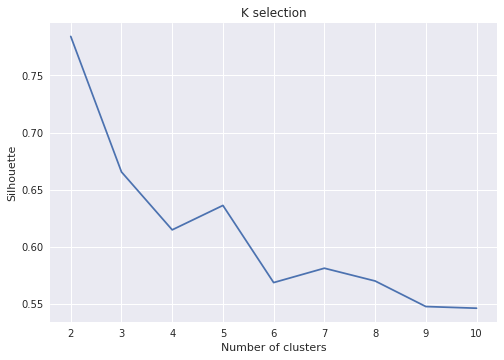

In [33]:
# Finding best k
plt.style.use("seaborn")
df_clustering = df_grouped.drop(['Neighborhood', 'Borough', 'Likes.range'],axis=1)
sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_clustering, labels, metric = 'euclidean'))
plt.plot(range(2,kmax+1),sil)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette")
plt.title("K selection")
plt.show()

### 2. Model fitting

In [34]:
# set number of clusters
kclusters = 2
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, init = 'random', n_init = 15).fit(df_clustering)
    
df_merged = df_grouped

# add clustering labels
df_merged['Clus_labels'] = kmeans.labels_

df_merged.head()

Neighborhood         Borough     Price  \
0                                 Baró de Viver     Sant Andreu  2.000000   
1                                      Can Baró  Horta-Guinardó  2.000000   
2                                     Canyelles      Nou Barris  2.000000   
3  Diagonal Mar i el Front Marítim del Poblenou      Sant Martí  1.857143   
4                                         Horta  Horta-Guinardó  2.444444   

     Rating      Likes  Likes.range  Argentinian  Asian   Chinese  Falafel  \
0  5.800000  24.000000     1.000000          0.0    1.0  0.000000      0.0   
1  7.285714  46.857143     1.142857          0.0    0.0  0.142857      0.0   
2  7.300000  17.000000     1.000000          0.0    0.0  0.000000      0.0   
3  7.271429  51.857143     1.142857          0.0    0.0  0.000000      0.0   
4  6.944444  11.333333     0.333333          0.0    0.0  0.000000      0.0   

   ...  Japanese  Mediterranean  Mexican  Paella  Seafood   Spanish  Sushi  \
0  ...       0.0       0.000000      0.0     0.0      0.0  0.000000    0.0   
1  ...       0.0       0.000000      0.0     0.0      0.0  0.571429    0.0   
2  ...       0.0       1.000000      0.0     0.0      0.0  0.000000    0.0   
3  ...       0.0       0.571429      0.0     0.0      0.0  0.285714    0.0   
4  ...       0.0       0.222222      0.0     0.0      0.0  0.333333    0.0   

      Tapas  Vegetarian / Vegan  Clus_labels  
0  0.000000                 0.0            0  
1  0.142857                 0.0            0  
2  0.000000                 0.0            0  
3  0.000000                 0.0            0  
4  0.444444                 0.0            0  

[5 rows x 23 columns]

### 3. Results Analysis

In [35]:
df_merged.Clus_labels.value_counts()

0    53
1     9
Name: Clus_labels, dtype: int64

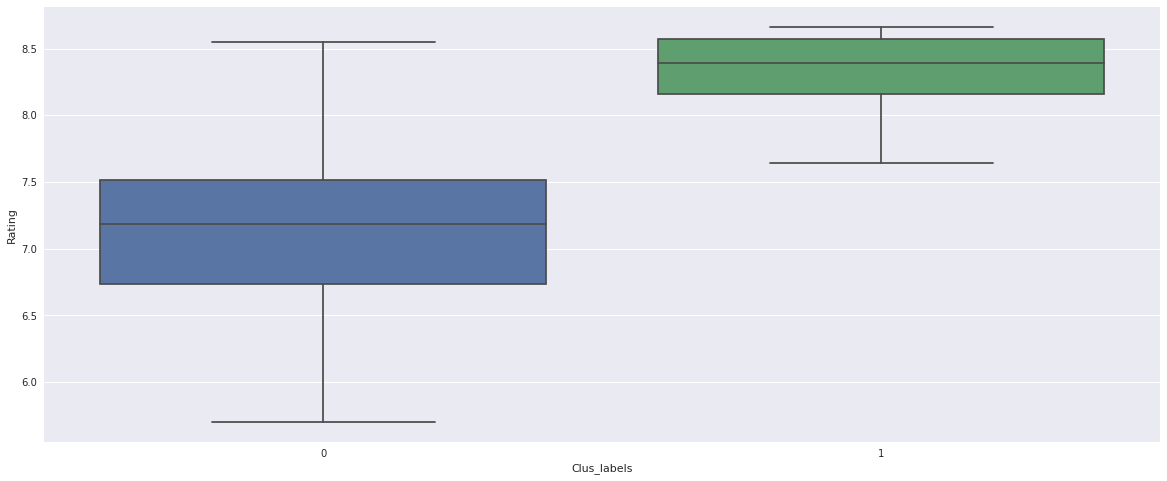

In [36]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Clus_labels',y='Rating',data=df_merged)
plt.show()

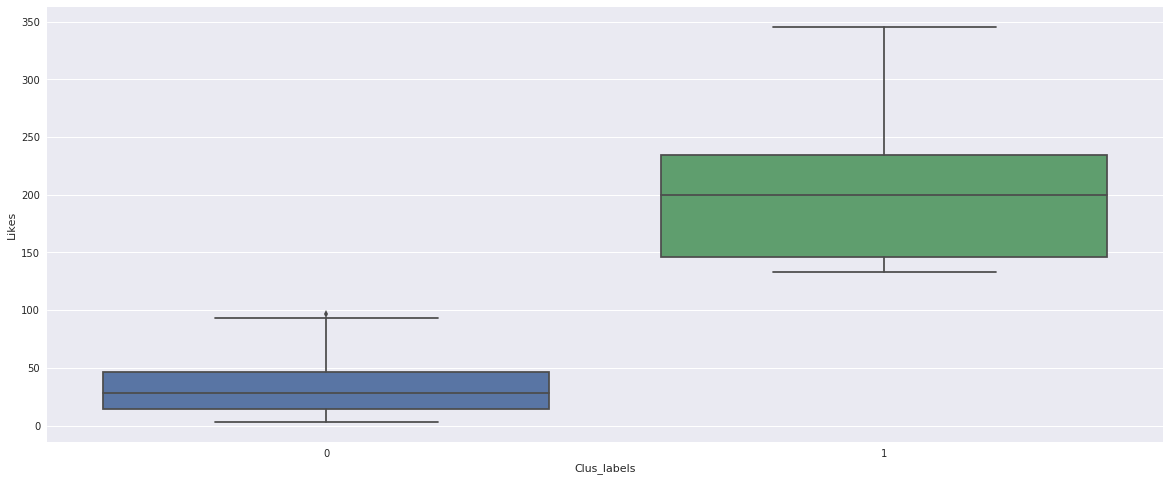

In [37]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Clus_labels',y='Likes',data=df_merged)
plt.show()

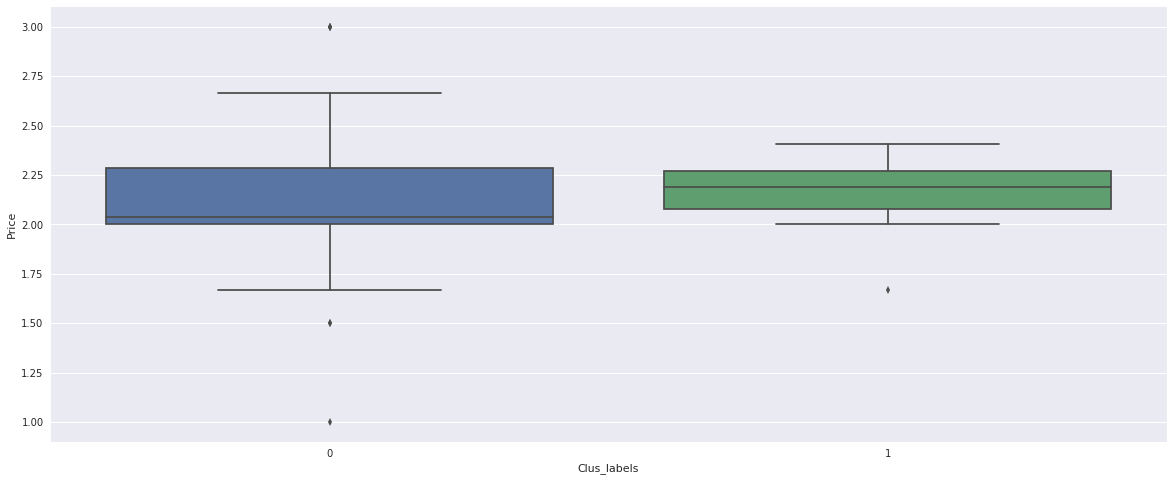

In [38]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Clus_labels',y='Price',data=df_merged)
plt.show()

In [39]:
# create a plain world map
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=12)

# generate choropleth
folium.Choropleth(
    geo_data=geoNeighborhood,
    data=df_merged,
    columns=['Neighborhood', 'Clus_labels'],
    key_on='properties.NOM',
    fill_color='BuGn',
    nan_fill_color='purple',
    nan_fill_opacity=0.5,
    threshold_scale=3,
    fill_opacity=0.8, 
    line_opacity=0.5
).add_to(map_bcn)


# display map
map_bcn

In [77]:
df3 = df_merged.groupby('Clus_labels').mean()
df3.drop(['Price','Likes','Likes.range','Rating'],axis=1, inplace=True)

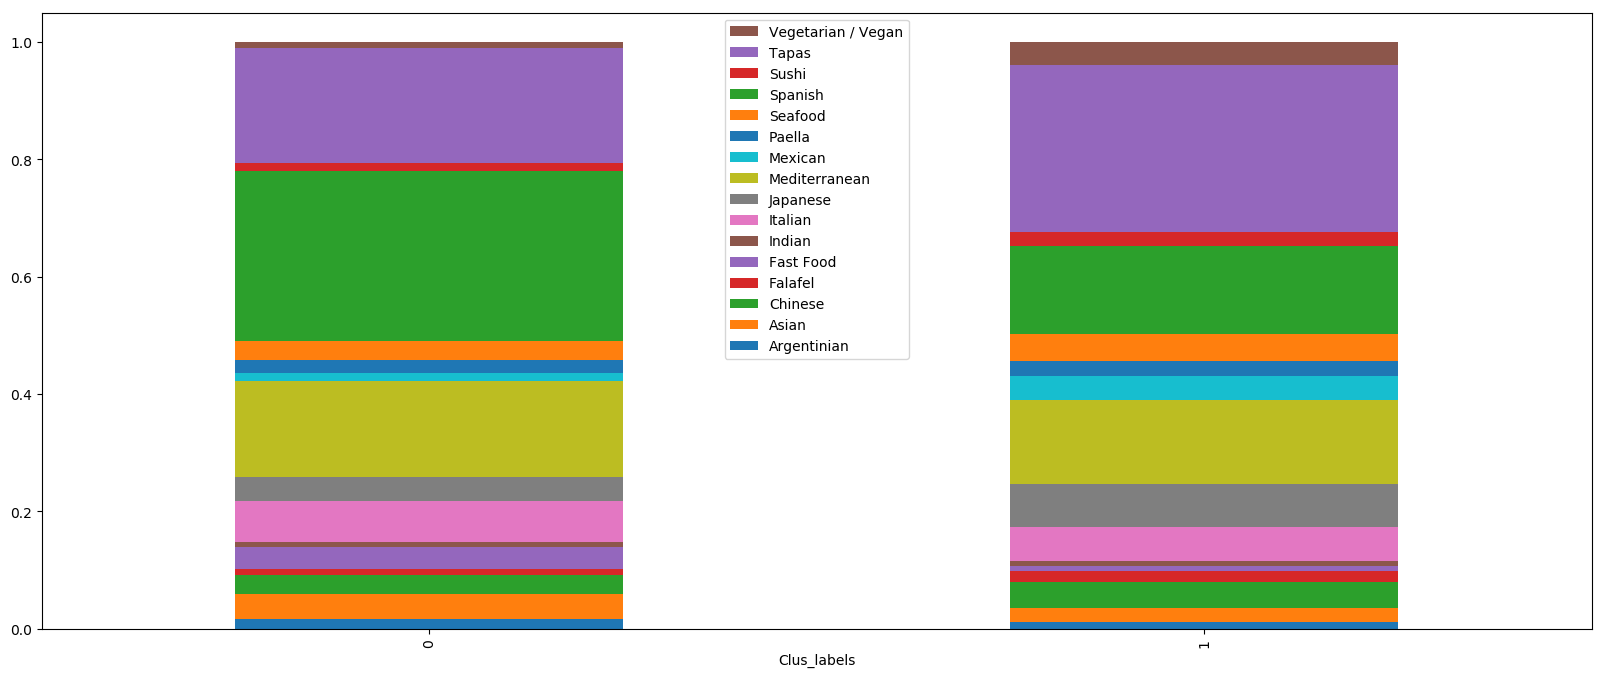

In [91]:
plt.style.use("default")
ax = df3.plot(kind='bar',stacked=True, figsize=(20,8))
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper center') 
plt.show()